In [6]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pickle

In [2]:
df = pd.read_csv('../products_sentiment_train.tsv', sep='\t', header=None)
df_test = pd.read_csv('../products_sentiment_test.tsv', sep='\t')
df.head()

,0,1
0,"2 . take around 10,000 640x480 pictures .",1
1,i downloaded a trial version of computer assoc...,1
2,the wrt54g plus the hga7t is a perfect solutio...,1
3,i dont especially like how music files are uns...,0
4,i was using the cheapie pail ... and it worked...,1


In [3]:
print(f'Train data shape: {df.shape}, \nna values:\n{df.isna().sum()}')
print(f'Classes balance:\n{df.iloc[:, 1].value_counts()}')

Train data shape: (2000, 2), 
na values:
0    0
1    0
dtype: int64
Classes balance:
1    1274
0     726
Name: 1, dtype: int64


In [4]:
# Отделю матрицу X и вектор y
# Отделю индексы(дальше понадобится в submit) и тестовую матрицу X_test
X, y = df.iloc[:, 0].values, df.iloc[:, 1].values
ids, X_test = df_test.iloc[:, 0].values, df_test.iloc[:, 1].values

In [36]:
%%writefile lemmatizer.py
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import WordNetLemmatizer
import numpy as np

# Практика показала, что лемматизация даёт небольшой прирост качества
# Класс трансформера для использования в Pipeline
class Lemmatizer(BaseEstimator, TransformerMixin):
    """Transformer for lemmatizing words."""
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        
    def fit(self, texts, y=None):
        return self
    
    def transform(self, texts):
        return np.array([' '.join([self.lemmatizer.lemmatize(word) for word in text.split()]) for text in texts])

Overwriting lemmatizer.py


Далее я посмотрю различные комбинации SVC(Support vector classifier)|Logistic regression с признаками CountVectorizer|TfIdfVectorizer. В данной работе другие методы не рассматривал, остановился на базовых методах. Исходя из результатов выберу лучшую пару и буду её настраивать.

In [6]:
# token_pattern - регулярное выражение для извлечения токенов из документов, таким выражением получилось чуть лучше качество
# На этом этапе использую стоп-слова, а также балансировку классов в классификаторе
pipe = Pipeline([('Lemmatizer', Lemmatizer()),
                 ('Vectorizer', CountVectorizer(token_pattern=r'[a-zA-Z\d]+', stop_words=stopwords.words('english'))),
                 ('Estimator', LogisticRegression(class_weight='balanced'))])
cv_score = cross_val_score(pipe, X, y)
print(f'Mean accuracy score for this pipeline: {cv_score.mean()}')

Mean accuracy score for this pipeline: 0.7484999999999999


In [7]:
pipe = Pipeline([('Lemmatizer', Lemmatizer()),
                 ('Vectorizer', CountVectorizer(token_pattern=r'[a-zA-Z\d]+', stop_words=stopwords.words('english'))),
                 ('Estimator', SVC())])
cv_score = cross_val_score(pipe, X, y)
print(f'Mean accuracy score for this pipeline: {cv_score.mean()}')

Mean accuracy score for this pipeline: 0.7415


In [8]:
pipe = Pipeline([('Lemmatizer', Lemmatizer()),
                 ('Vectorizer', TfidfVectorizer(token_pattern=r'[a-zA-Z\d]+', stop_words=stopwords.words('english'))),
                 ('Estimator', LogisticRegression(class_weight='balanced'))])
cv_score = cross_val_score(pipe, X, y)
print(f'Mean accuracy score for this pipeline: {cv_score.mean()}')

Mean accuracy score for this pipeline: 0.7464999999999999


In [9]:
pipe = Pipeline([('Lemmatizer', Lemmatizer()),
                 ('Vectorizer', TfidfVectorizer(ngram_range=(1, 2),
                                                token_pattern=r'[a-zA-Z\d]+', 
                                                stop_words=stopwords.words('english'))),
                 ('Estimator', SVC(class_weight='balanced'))])
cv_score = cross_val_score(pipe, X, y)
print(f'Mean accuracy score for this pipeline: {cv_score.mean()}')

Mean accuracy score for this pipeline: 0.765


In [10]:
# Baseline submit
pipe.fit(X, y)
baseline_predictions = pipe.predict(X_test)

In [11]:
pd.Series(baseline_predictions, index=ids).to_csv('Baseline_submit.csv', header=['y'], index_label='Id')

In [12]:
# Удаление стоп-слов ухудшает качество на кросс-валидации
pipe = Pipeline([('Lemmatizer', Lemmatizer()),
                 ('Vectorizer', TfidfVectorizer(ngram_range=(1, 2), 
                                                token_pattern=r'[a-zA-Z\d\(\)]{1,}',
                                                )),
                 ('Estimator', SVC(class_weight='balanced'))])
cv_score = cross_val_score(pipe, X, y)
print(f'Mean accuracy score for this pipeline: {cv_score.mean()}')

Mean accuracy score for this pipeline: 0.7965


In [13]:
# Посмотрим на нечисловые и нетекстовые токены, возможно есть смысл взять смайлики или что-то подобное
non_words = set()
for i in X:
    for item in i.split():
        non_words.add(re.sub(r'[A-Za-z\d]+', '', item))
non_words

{'',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 '&#;',
 "'",
 '(',
 ')',
 ').',
 '*',
 '+',
 ',',
 '-',
 '--',
 '---',
 '.',
 '.--',
 '..',
 '...',
 '....',
 '/',
 ':',
 ';',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '~'}

In [14]:
# Класс для препроцесинга(не понабобился, так как не повлиял на качество в лучшую сторону)
class TextPreprocessor(BaseEstimator, TransformerMixin):
    """Transformer for lemmatizing words."""
    def __init__(self):
        pass
        
    def fit(self, texts, y=None):
        return self
    
    def transform(self, texts):
        return np.array([text.replace(" 've", 'have').replace(" n't", 'not').replace(" 's", 'is').replace(" 'll", 'will').replace("'ve", ' have').replace("n't", ' not').replace("'s", ' is').replace("'ll", ' will').replace("n't", "not").replace("n 't", " not")
                         for text in texts])

In [8]:
# Первый пайплайн, дающий 80+ на кросс-валидации
# Здесь применяю сразу два метода создания признаков и объединяю в FeatureUnion
union = FeatureUnion([('First_transormer', TfidfVectorizer(ngram_range=(1, 2), 
                                                           token_pattern=r'[a-zA-Z\(\)\d]+')),
                      ('Second_transformer', TfidfVectorizer(ngram_range=(1, 8),
                                                             analyzer='char_wb',
                                                             token_pattern=r'[a-zA-Z\d\(\)]+'))])
pipe = Pipeline([('Vectorizer', union),
                 ('Estimator', LogisticRegression(class_weight='balanced'))])
cv_score = cross_val_score(pipe, X, y)
print(f'Mean accuracy score for this pipeline: {cv_score.mean()}')
pipe.fit(X, y)
with open('pipeline_from_kaggle.pkl', 'wb') as file:
    pickle.dump(pipe, file)

Mean accuracy score for this pipeline: 0.7870000000000001


In [17]:
with open('pipeline_from_kaggle.pkl', 'rb') as file:
    pipe = pickle.load(file)
pipe

Pipeline(steps=[('Vectorizer',
                 FeatureUnion(transformer_list=[('First_transormer',
                                                 TfidfVectorizer(ngram_range=(1,
                                                                              2),
                                                                 token_pattern='[a-zA-Z\\(\\)\\d]+')),
                                                ('Second_transformer',
                                                 TfidfVectorizer(analyzer='char_wb',
                                                                 ngram_range=(1,
                                                                              8),
                                                                 token_pattern='[a-zA-Z\\d\\(\\)]+'))])),
                ('Estimator', SVC(class_weight='balanced'))])

In [ ]:
import joblib


In [12]:
# first 80+ submit
pipe.fit(X, y)
predictions = pipe.predict(X_test)
pd.Series(predictions, index=ids).to_csv('first_80+_submit.csv', header=['y'], index_label='Id')

In [13]:
# Делаем файл pickle из обученной модели
import pickle


with open('pipeline_from_kaggle.pkl', 'wb') as file:
    pickle.dump(pipe, file)

In [31]:
pipe.predict(['movie is good',
              'i like this movie a nice film'])

array([1, 1], dtype=int64)

In [17]:
# Попробуем настроить на логистическую регрессию
pipe = Pipeline([('Lemmatizer', Lemmatizer()),
                 ('Vectorizer', union),
                 ('Estimator', LogisticRegression(penalty='l2',
                                                  C=1,
                                                  class_weight='balanced'))])
cv_score = cross_val_score(pipe, X, y)
print(f'Mean accuracy score for this pipeline: {cv_score.mean()}')

Mean accuracy score for this pipeline: 0.791


In [18]:
# SVC с набором признаков даёт лучшее качество, будем брать его.
# Можно еще поработать с train набором данных, чтобы улучшить качетсво
# Кажется стоит заменить апострафы по типу 've, 's, n't, 'll на have, is, not, will
# Стоит добавить тире в парсинг токенов
# Стоит добавить точки и запятые в парсинг токенов (числа, сокращения)
for document in X:
    for word in document.split():
        if any([symbol in non_words for symbol in word]):
            print(word)

.
10,000
.
.
hard-walled
.
;
,
.
...
.
,
,
,
.
)
-
-
hard-drive
,
,
3-1
/
.
-
,
(
n't
)
.
,
!
.
's
're
.
,
.
.
,
non-tech
(
)
$
tech-support
.
.
's
(
,
,
)
.
,
,
't
.
$
.
,
.
,
.
've
.
n't
.
-
,
,
.
,
.
.
.
:
,
(
)
,
.
,
,
hi-tech
.
"
"
-
.
,
,
.
.
/
.
.
)
(
)
,
.
.
t-mobile
.
!
(
/
.
--
>
,
's
.
,
.
.
.
,
,
,
.
.
.
.
!
,
(
)
.
focus-lock
.
,
mega-static
,
'd
6-7
.
,
.
about-
,
.
'm
.
.
,
(
)
(
)
i-75
,
&#38;
's
.
.
.
...
:
-touchy
...
's
't
'
.
.
:
.
'm
're
,
've
,
!
's
,
,
,
relatively-intuitive
,
(
-
)
.
.
.
.
)
/
/
.
(
!
)
.
.
;
.
,
.
.
,
.
,
,
't
!
,
's
!
!
)
--
,
,
,
.
.
,
've
,
,
,
,
"
ccapp.exe
"
.
.
(
)
.
,
's
.
once-in-a-while
,
.
,
.
(
,
,
,
)
.
/
"
/
"
.
,
.
.
.
.
-
.
.
't
.
,
on-line
.
.
!
.
(
)
,
.
;
,
's
.
,
.
,
't
,
.
n't
.
,
--
.
,
't
"
"
.
2.0
.
:
's
.
,
-
!
't
,
'd
,
(
,
$
)
.
,
anti-virus
.
's
.
,
't
.
.
,
.
!
's
,
n't
-
're
.
:
,
,
,
.
!
's
.
,
.
.
.
,
$
.
.
.
.
two-times
,
,
two-piece
shutter-like
.
,
'm
.
've
.
:
,
stand-up
.
's
.
.
n't
.
,
.
(
)
.
,
!
,
,
.
,
,


%
.
"
"
.
,
.
(
)
,
.
'm
(
)
,
...
.
.
)
(
's
s-1
)
,
(
's
)
!
's
,
.
's
's
.
.
,
.
.
,
(
4-5
4-5
)
,
,
(
's
)
.
.
/
.
.
.
--
.
:
,
.
't
,
've
.
,
't
've
.
,
,
.
,
.
,
,
,
micro-adjustable
,
.
,
,
.
,
'd
.
.
,
.
,
,
"
"
,
,
,
/
,
etc.
,
.
,
$
.
.
,
(
,
,
,
)
.
's
.
,
's
,
,
'
'
.
're
.
,
,
,
.
.
,
.
-
't
't
,
't
,
.
(
)
.
2-megapixel
,
.
"
"
.
,
,
,
,
.
.
,
.
,
%
.
,
,
.
.
)
--
n't
.
.
's
.
,
.
't
.
't
.
,
.
,
:
battery--
,
.
,
,
(
)
't
.
'm
;
,
!
:
(
)
,
's
.
.
,
"
"
.
.
.
.
,
.
,
.
.
's
.
.
!
$
.
,
,
.
.
n't
.
.
,
,
't
.
.
$
6.00
.
.
)
.
.
.
-
.
.
,
(
)
.
dial.
't
(
n't
,
.
)
,
't
.
,
,
.
,
,
!
,
.
't
,
,
.
.
't
,
.
,
.
'm
,
,
,
.
.
:
,
,
multi-format
.
.
:
,
'
'
.
,
.
well-
.
(
)
,
.
mega-pixel
.
.
,
's
....
,
,
.
,
.
.
:
,
.
.
"
.
"
1-touch
,
.
't
.
/
.
)
-
.
.
't
.
.
(
)
.
)
,
.
,
,
'
set-up
,
(
i.e.
)
.
's
!
,
(
)
,
.
't
.
.
,
'm
.
,
,
.
,
'm
.
auto-focus
.
above-mentioned
,
,
.
't
's
short-comings
,
.
,
'm
,
.
;
)
's
.
,
.
've
,
,
:
's
.
-
-
.
,
-
'll
,
!
.
.
.
,
,
'll
.
(
)
's


In [100]:
union = FeatureUnion([('First_transormer', CountVectorizer(ngram_range=(1, 2), 
                                                           token_pattern=r'[a-zA-Z\(\)\-\d,.]+',
                                                           max_df=0.70,
                                                           min_df=2,
                                                           stop_words=stop_ws)),
                      ('Second_transformer', CountVectorizer(ngram_range=(3, 5),
                                                             stop_words=stop_ws,
                                                             analyzer='char_wb',
                                                             token_pattern=r'[a-zA-Z\d\-]+'))])
clf_pipe = Pipeline([('Preproc', TextPreprocessor()),
                     ('Lemmatizer', Lemmatizer()),
                     ('Vectorizer', union),
                     ('Transformer', TfidfTransformer(sublinear_tf=True)),
                     ('Estimator', SVC(C=1, class_weight='balanced'))])
cv_score = cross_val_score(clf_pipe, X, y)
print(f'Mean accuracy score for this pipeline: {cv_score.mean()}')

Mean accuracy score for this pipeline: 0.7959999999999999


In [97]:
# second 80+ submit
clf_pipe.fit(X, y)
predictions = clf_pipe.predict(X_test)
pd.Series(predictions, index=ids).to_csv('second_80+_submit.csv', header=['y'], index_label='Id')

In [91]:
stop_ws = ['.', ',', 'a', 'and', 'in', 'the', 'to', 'n', 't', '--', 'of', 'd', 'm']

In [20]:
# Просмотр токенов
for document in X:
    print(re.findall(r'[a-zA-Z\(\)\-\d,.]+', document))

['2', '.', 'take', 'around', '10,000', '640x480', 'pictures', '.']
['i', 'downloaded', 'a', 'trial', 'version', 'of', 'computer', 'associates', 'ez', 'firewall', 'and', 'antivirus', 'and', 'fell', 'in', 'love', 'with', 'a', 'computer', 'security', 'system', 'all', 'over', 'again', '.']
['the', 'wrt54g', 'plus', 'the', 'hga7t', 'is', 'a', 'perfect', 'solution', 'if', 'you', 'need', 'wireless', 'coverage', 'in', 'a', 'wider', 'area', 'or', 'for', 'a', 'hard-walled', 'house', 'as', 'was', 'my', 'case', '.']
['i', 'dont', 'especially', 'like', 'how', 'music', 'files', 'are', 'unstructured', 'basically', 'they', 'are', 'just', 'dumped', 'into', 'one', 'folder', 'with', 'no', 'organization', ',', 'like', 'you', 'might', 'have', 'in', 'windows', 'explorer', 'folders', 'and', 'subfolders', '.']
['i', 'was', 'using', 'the', 'cheapie', 'pail', '...', 'and', 'it', 'worked', 'ok', 'until', 'the', 'opening', 'device', 'fell', 'apart', '.']
['you', 'can', 'manage', 'your', 'profile', ',', 'change', 

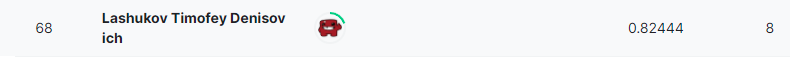